# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
#!pip install workspace_utils

In [158]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics


import xgboost as xgb
from timeit import timeit
import time



#import workspace_utils
#from workspace_utils import active_session
 


import seaborn as sns
import ast
pd.options.mode.chained_assignment = None
#import warnings
#warnings.filterwarnings("ignore")

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data

#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_csv('azdias.csv', sep=';')
customers = pd.read_csv('customers.csv', sep=';')



/var/folders/d0/tf150l_x1c99_t8sk43b8s1m0000gn/T/ipykernel_92009/2645263048.py:6: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('azdias.csv', sep=';')
/var/folders/d0/tf150l_x1c99_t8sk43b8s1m0000gn/T/ipykernel_92009/2645263048.py:7: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('customers.csv', sep=';')


In [4]:
#customers.to_csv('customers.csv',sep=';')

In [5]:
#azdias.to_csv('azdias.csv',sep=';')

In [6]:
azdias.shape

(891221, 367)

In [7]:
customers.shape

(191652, 370)

# Part 0: Look at the Data


### a.1)- Customers DataFrame:  Demographics data for customers of a mail-order company

In [8]:
customers.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [9]:
customers.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [10]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [11]:
# Differences features between customers and azdias
differences = set(customers) - set(azdias)
print('Number of features exclusively in customers: ', len(differences), '\n')
print(differences)

Number of features exclusively in customers:  3 

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


In [12]:
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

### - Analizing missing data in customers dataframe

In [13]:
# Number of no missing columns
n_no_missing_columns = len(customers.columns[customers.isnull().mean()==0])
print(n_no_missing_columns)

94


In [14]:
# Sum nulls values in each row
sum(customers.isnull().sum(axis=1))


13864522

In [15]:
# In the first look in the data we can see there is a lot of null data

In [16]:
### output percentage of values that are missing by columns
#missing_cols = 100 * customers.isnull().sum() / customers.shape[0]
missing_cols_customers = customers.isnull().mean(axis=1) * 100
missing_cols_customers



0          1.362398
1         67.029973
2          1.362398
3          2.179837
4          1.362398
            ...    
191647     1.634877
191648     4.087193
191649     1.634877
191650     1.089918
191651     1.089918
Length: 191652, dtype: float64

Text(0.5, 1.0, 'Proportion of missing values in Customers features')

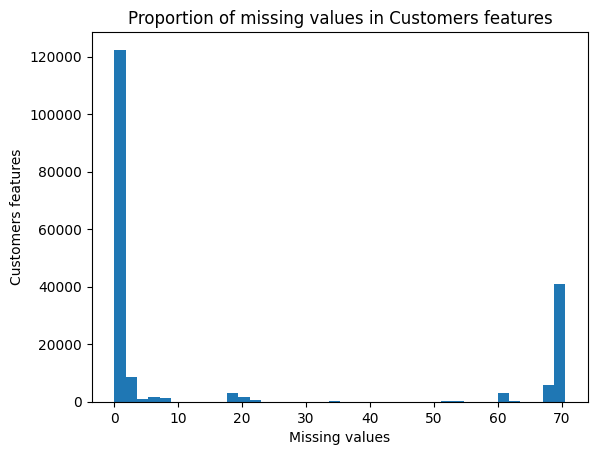

In [17]:
plt.hist(missing_cols_customers, bins=40);

plt.xlabel('Missing values')
plt.ylabel('Customers features')
plt.title('Proportion of missing values in Customers features')


In [18]:

#Most of the columns have percentage of missing values of less than 30%. 

In [19]:
## Function to detect nulls in columns

def find_columns_nulls(df,percent) :
    
    '''
    Find the columns with null bigger than 'percent'
    
    :df -> it´s the dataframe to explore for null in columns
    :percent-> its the % of columns with null values
   
    :return ->list_columns_nulls: its a list with more than  percent of null values
    '''
    
    list_columns_nulls = []

    for col in df.columns:

           if  ((df[col].isnull().sum()/df.shape[0])>percent):
                
     
            list_columns_nulls.append(col)       
            
        
    return list_columns_nulls

In [20]:

list_customers_columns_nulls = find_columns_nulls(customers,0.30)

print(list_customers_columns_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [21]:
## Function to show columns with nulls

def display_null_columns(df,name,list_nulls,percent) :
    
    '''
    Show the plot where the columns of dataframe (dt) has more than 'percent' of nulls values
    
    :df -> it´s the dataframe to explore for null in columns
    :list_nulls -> list with nulls columns
    
    :return ->show the plot
    '''
    
    
    nombre = str(df)
    data=[]
    #data = [i for i in (df.isna().sum()/df.shape[0]) if i >=percent]
    
    for i in (df.isna().sum()/df.shape[0]):
          if (i >=percent):
                print(i)
                data.append(i)
                

    y_pos = np.arange(len(list_nulls))

    
    f, ax = plt.subplots(figsize=(5,8))
    plt.barh(y_pos, data, align='center', alpha=percent,color =sns.color_palette("dark:#5A9_r"))
    plt.yticks(y_pos, list_nulls)
    plt.xlabel('%')
    plt.title('Percentage of columns in DataFrame: {}'.format(name))


   
    return  plt.show()
            
  

0.9386074760503412
0.9733892680483376
0.9933473170120845
0.9987686014234133
0.44498883392816146
0.5840638240143594


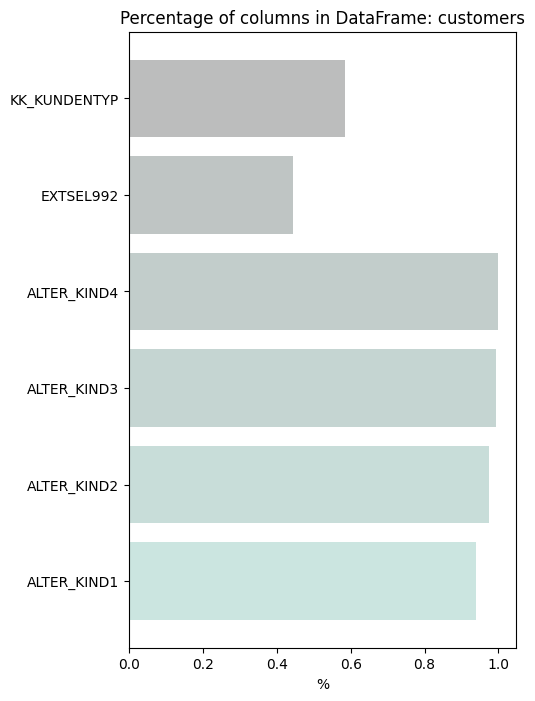

In [22]:
display_null_columns(customers,'customers',list_customers_columns_nulls,0.30)

### - Dropping columns

In [23]:
customers.drop(list_customers_columns_nulls, axis=1,inplace=True)


In [24]:
### Analizing warnings

In [25]:
#columns with categorical values
customers.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W


### a.2) General AZDIAS DataFrame: Demographics data for the general population of Germany

In [26]:
### a)- Customers DataFrame:

In [27]:
azdias.head()


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [28]:

azdias.describe()


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486466,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [29]:
azdias.shape

(891221, 367)

### - Analizing missing data in AZDIAS dataframe

In [30]:
# Number of no missing columns
n_no_missing_columns = len(azdias.columns[azdias.isnull().mean()==0])
print(n_no_missing_columns)

94


In [31]:
###DROPING COLUMNS

In [32]:
### output percentage of values that are missing by columns

missing_cols_azdias = azdias.isnull().mean(axis=1) * 100
missing_cols_azdias


0         68.664850
1          4.087193
2          1.362398
3          1.907357
4          1.362398
            ...    
891216     2.997275
891217     1.634877
891218     2.179837
891219     1.089918
891220     4.359673
Length: 891221, dtype: float64

Text(0.5, 1.0, 'Proportion of missing values in Customers features')

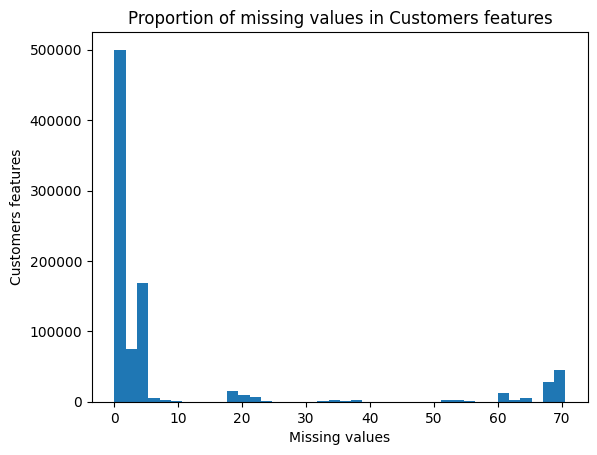

In [33]:
plt.hist(missing_cols_azdias, bins=40);

plt.xlabel('Missing values')
plt.ylabel('Customers features')
plt.title('Proportion of missing values in Customers features')

In [34]:
# In The histogram showed above we can see most of the columns with  missing values has less than 20%.

# We are going to choose  threshold as 20%


In [35]:
# Sum nulls values in each row
sum(azdias.isnull().sum(axis=1))


33492923

In [36]:
# List of columns with a more than  % nulls
list_azdias_columns_nulls = find_columns_nulls(azdias,0.20)


print(list_azdias_columns_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']


0.9090483729624863
0.9669004657655059
0.9930769135826019
0.9986479223447383
0.29504129727643313
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.2884952217239046
0.7339963937115486
0.6559674873011295


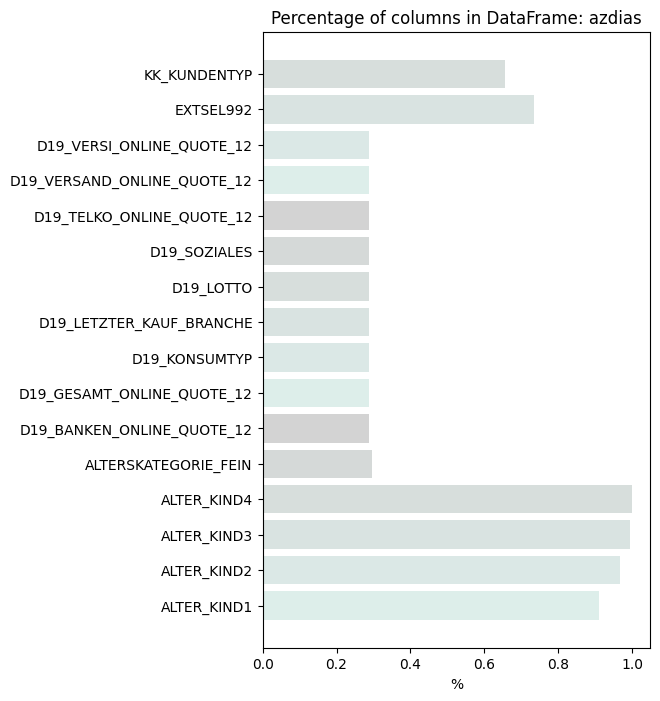

In [37]:
# showing the number of columns with % nulls
display_null_columns(azdias,'azdias',list_azdias_columns_nulls,0.20)


### - Dropping columns

In [38]:
azdias.drop(list_azdias_columns_nulls,axis=1,inplace=True)

In [39]:
# checking AZDIAS dataset shape
azdias.shape

(891221, 351)

In [40]:
### output percentage of values that are missing by columns
missing_cols_azdias = azdias.isnull().mean(axis=1) * 100
missing_cols_azdias

0         67.236467
1          0.000000
2          0.000000
3          0.569801
4          0.000000
            ...    
891216     1.709402
891217     0.000000
891218     0.569801
891219     0.000000
891220     0.000000
Length: 891221, dtype: float64

Text(0.5, 1.0, 'Proportion of missing values in Customers features')

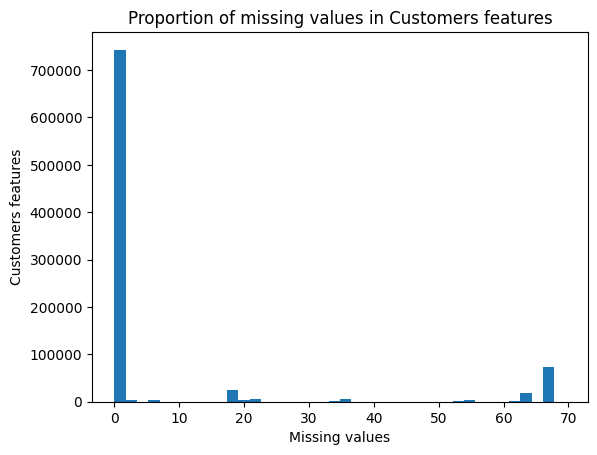

In [41]:
plt.hist(missing_cols_azdias, bins=40);

plt.xlabel('Missing values')
plt.ylabel('Customers features')
plt.title('Proportion of missing values in Customers features')

In [42]:
# we still have missing 
azdias = azdias[missing_cols_azdias <= 10]

In [43]:
azdias.shape

(751331, 351)

In [44]:
#columns with categorical values
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8.0,51.0,1992-02-10 00:00:00,W
2,4C,4.0,24.0,1992-02-12 00:00:00,W
3,2A,2.0,12.0,1997-04-21 00:00:00,W
4,6B,6.0,43.0,1992-02-12 00:00:00,W
5,8C,8.0,54.0,1992-02-12 00:00:00,W


In [45]:
customers.shape

(191652, 361)

### b.1) Loading Attributes files

In [46]:
dias_attributes_val = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
dias_attributes_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)


In [47]:
#dias_attributes_val

In [48]:
#dias_attributes_levels

### b.2) Discard columns with nulls in atributes file 


In [49]:
dias_attributes_val_new = dias_attributes_val[dias_attributes_val.index.isin(list_azdias_columns_nulls)==False]
dias_attributes_val_new.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [50]:
dias_attributes_levels_new = dias_attributes_levels[dias_attributes_levels.index.isin(list_azdias_columns_nulls)==False]
dias_attributes_levels_new.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### b.3a) Refill the "Information level" column with ffil in attibutes info file

In [51]:
dias_attributes_levels_new.reset_index(drop=True, inplace=True)
dias_attributes_levels_new['Information level'].ffill(inplace=True)
dias_attributes_levels_new

dias_attributes_levels_new['Information level'].isnull().sum()

1

In [52]:
#we have still one null in Information level, we are going to apply bfill

In [53]:
dias_attributes_levels_new['Information level'].bfill(inplace=True)
dias_attributes_levels_new.head(25)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,Person,ANREDE_KZ,gender,NaN
3,NaN,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [54]:
dias_attributes_levels_new.drop(columns=['Unnamed: 0'], inplace=True)


### b.4) Refill the "Information level" column with ffil in attributes info file

In [55]:
# now all the column Information level is complete
#dias_attributes_levels_new['Information level'].isnull().sum()

In [56]:
### b.5) Filling the blanks 
#dias_attributes_levels_new.ffill(inplace=True)

In [57]:
#dias_attributes_levels_new.head(25)
#removing Additional notes
dias_attributes_levels_new.drop('Additional notes',axis=1,inplace=True)

In [58]:
### b.3a) Refill the  column with ffil in attibutes  values

In [59]:
dias_attributes_val_new.reset_index(drop=True, inplace=True)
dias_attributes_val_new.drop(columns=['Unnamed: 0'], inplace=True)
dias_attributes_levels_new
dias_attributes_val_new.ffill(inplace=True)
dias_attributes_val_new

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [60]:
### b.4) to list all the unknows values

In [61]:
dias_attributes_val_unknowns = dias_attributes_val_new.loc[dias_attributes_val_new.Meaning=='unknown', :][['Attribute', 'Value']]
dias_attributes_val_unknowns.head(20)

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,-1
105,CAMEO_DEUINTL_2015,-1
131,CJT_GESAMTTYP,0
391,D19_KK_KUNDENTYP,-1
647,EWDICHTE,-1


In [62]:
dias_attributes_val_unknowns.reset_index(drop=True, inplace=True)
#dias_attributes_unknowns.ffill(inplace=True)
dias_attributes_val_unknowns.head(20)


,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ANREDE_KZ,"-1, 0"
3,BALLRAUM,-1
4,BIP_FLAG,-1
5,CAMEO_DEUG_2015,-1
6,CAMEO_DEUINTL_2015,-1
7,CJT_GESAMTTYP,0
8,D19_KK_KUNDENTYP,-1
9,EWDICHTE,-1


In [63]:
### b.5) unknows. We can see there are differents kinds of unknows, for example -1,0 and both

In [64]:

def replaceUnknowns(df, attributes_unknowns):
    '''
      Replace unkowns values for nan from dataframe df 
      
      :df -> Dataframe to change the value of attributes with unknows values
      :attributes_unknowns -> list of attributes whose are unknow 
      
      return
      
    '''
    
    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(attributes_unknowns['Attribute']):
            continue
        
        unknown_value = attributes_unknowns.loc[attributes_unknowns['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    
      
    
    return df

In [65]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,0.0,3.0,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,2,143872,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,3,143873,1,1.0,8.0,8.0,0.0,NaN,0.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,4,143874,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [66]:

customer = replaceUnknowns(customers, dias_attributes_val_unknowns)
customer.head(10)


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,9626.0,2.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,1.0,9628.0,NaN,9.0,11.0,NaN,NaN,NaN,0.0,3.0,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3.0,1.0,4.0
2,2.0,143872.0,NaN,1.0,6.0,0.0,1.0,0.0,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
3,3.0,143873.0,1.0,1.0,8.0,8.0,0.0,NaN,0.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1.0,1.0,4.0
4,4.0,143874.0,NaN,1.0,20.0,14.0,7.0,0.0,0.0,4.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0
5,5.0,143888.0,1.0,1.0,11.0,10.0,1.0,0.0,0.0,2.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2.0,1.0,3.0
6,6.0,143904.0,2.0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1.0,1.0,4.0
7,7.0,143910.0,1.0,1.0,10.0,9.0,1.0,0.0,0.0,2.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3.0,1.0,4.0
8,8.0,102160.0,2.0,3.0,5.0,4.0,74.0,2.0,0.0,1.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3.0,2.0,4.0
9,9.0,102173.0,1.0,1.0,20.0,13.0,1.0,0.0,0.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1.0,1.0,3.0


In [67]:
azdias = replaceUnknowns(azdias, dias_attributes_val_unknowns)
azdias.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,1.0,910220.0,NaN,9.0,0.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,2.0,910225.0,NaN,9.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,3.0,910226.0,2.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,4.0,910241.0,NaN,1.0,20.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,5.0,910244.0,3.0,1.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
6,6.0,910248.0,NaN,9.0,0.0,4.0,0.0,0.0,1.0,3.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
7,7.0,910261.0,NaN,1.0,14.0,6.0,0.0,0.0,1.0,5.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
8,8.0,645145.0,NaN,9.0,16.0,2.0,1.0,0.0,1.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6.0,1.0,3.0
9,9.0,645153.0,NaN,5.0,17.0,9.0,0.0,0.0,1.0,7.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0
10,10.0,645165.0,0.0,1.0,10.0,6.0,0.0,0.0,1.0,6.0,...,4.0,8.0,11.0,10.0,6.0,9.0,5.0,3.0,2.0,3.0


In [68]:
### Analizing warning in CUSTOMERS AND AZDIAS

In [69]:
dias_attributes_val_new[dias_attributes_val_new["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [70]:
# Checking name´s attribue por CAMEO_DEUG
dias_attributes_val_new[dias_attributes_val_new["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,24,Prosperous Households-Older Families & Mature ...


In [71]:

def ToEncode_cols_PRAEGENDE(val):
    
    '''
    Re-encoding for the column -PRAEGENDE_JUGENDJAHRE-
    
    :val-> it´s the value to encode
    
    :return -> 0: Mainstream, 1: Avangarde
    '''
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    
    if val in mainstream: 
        return 0
    elif val in avantgarde: 
        return 1
    else:
        return val

In [72]:


def ToEncode_cols_LP_(df):
    
    '''
    Re-encoding for  all the columns -LP_*-
    replacing zero with NaN values, dropping duplicate columns
    
    
    :df-> dataframe to treat LP_* columns
    
    :return df with encoding columns
    
    '''
    # droping complex and/or duplicate columns
    df.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN'], axis=1, inplace=True)
  
    # replacing 0s with NaN values
    cols = ["LP_LEBENSPHASE_FEIN","LP_LEBENSPHASE_GROB", "LP_FAMILIE_GROB"]
    df[cols] = df[cols].replace({0: np.nan})
    
    
    # re-encode LP_STATUS_GROB and LP_FAMILIE_GROB
    status = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3,  7: 3, 8: 4, 9: 4, 10: 5}
    familie = {1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 4, 7: 4, 8: 4, 9: 5, 10: 5, 11: 5}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(status)                                              
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(familie)    
    
    return df

In [73]:
def processData(df, attributes_values, nan_threshold,nameDF):
     
    '''
    Cleaning data, and preprocessing in dataframe df
    
    :df-> DataFrame to treat data to clean up
    :attributes_values-> DataFrame attributes to located unknows values
    :nan_threshold-> limit for dropping rows with more than % NaN values
        
        
    :return df-> df cleaned and preprocessed
    
    '''
    
    df.drop(columns=['Unnamed: 0'], inplace=True)
    
    print("1. Replacing X, XX with NaN")
    #replacing values X, XX with NaN values 
    df.replace('X',np.nan,inplace=True)
    df.replace('XX',np.nan,inplace=True)
    
    print("2. Dropping rows with missing values higher than {}".format(nan_threshold))
    
    # dropping rows with %missing values highter than nan_threshold
    percent_missing_row = df.isnull().mean(axis=1) * 100
    df = df[percent_missing_row <= nan_threshold]
    
    
    print("3. Re-encoding EINGEFUEGT_AM")
 

    # Re-encoding CATEGORICAL & MIXED FEATURES. Processing datetime
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    
    print("4. Processing CAMEO_DEUG_2015")
  
    # treat 'X' and 'XX' as nan values
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
 
    print("5. ncoding binaries values")
    # Encoding binaries values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    
    # dropping categorical variables
    if (nameDF=='customers' or nameDF=='mailout_train'):
        print("6. Dropping CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM")
        
        df.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)
    else:
        print("6. Dropping CAMEO_DEU_2015,EINGEFUEGT_AM")
        
        df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)
   
    
    print("7. Spliting CAMEO_INTL_2015 in Wealth_level and Status")
   
    # Splitting CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['CAMEO_INTL_2015_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    print('8. Encoding cols starting LP* an cols PRAEGENDE_JUGENDJAHRE')
 
    # Re encoding columns LP*
    df = ToEncode_cols_LP_(df)
   
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: ToEncode_cols_PRAEGENDE(x))


    # impute missing values
    
   
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
    df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    


    
    return df

### c.1) Processing data includes cleaning data and encoding data for customers and azdias DataFrames

In [74]:
customers_processed = processData(customers,dias_attributes_val_new, 20,"customers")

1. Replacing X, XX with NaN
2. Dropping rows with missing values higher than 20
3. Re-encoding EINGEFUEGT_AM
4. Processing CAMEO_DEUG_2015
5. ncoding binaries values
6. Dropping CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
7. Spliting CAMEO_INTL_2015 in Wealth_level and Status
8. Encoding cols starting LP* an cols PRAEGENDE_JUGENDJAHRE


In [75]:
customers_processed.shape

(139286, 356)

In [76]:
azdias_processed = processData(azdias,dias_attributes_val_new, 20,"azdias")

1. Replacing X, XX with NaN
2. Dropping rows with missing values higher than 20
3. Re-encoding EINGEFUEGT_AM
4. Processing CAMEO_DEUG_2015
5. ncoding binaries values
6. Dropping CAMEO_DEU_2015,EINGEFUEGT_AM
7. Spliting CAMEO_INTL_2015 in Wealth_level and Status
8. Encoding cols starting LP* an cols PRAEGENDE_JUGENDJAHRE


In [77]:
azdias_processed.shape

(751217, 347)

### c.2)  Data scaled


Using Data scaling  we are doing a  pre-process step. 
This estimator scales and translates each feature individually so that it falls in the given range in the training set.

Before use PCA we need to scale features to be of the same range.  PCA algorithm needs to have same scales in the features may be influenced by variations 


In [78]:
customers_processed

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH_LEVEL,CAMEO_INTL_2015_STATUS
0,9626.0,2.000000,1.0,10.0,10.0,1.0,0.00000,0.0,2.0,1.0,...,3.0,2.0,6.000000,9.0,7.0,3.0,1.0,4.0,1.0,3.0
1,143872.0,1.572672,1.0,6.0,0.0,1.0,0.00000,0.0,1.0,1.0,...,13.0,11.0,6.000000,9.0,2.0,3.0,2.0,4.0,3.0,4.0
2,143873.0,1.000000,1.0,8.0,8.0,0.0,0.06455,0.0,0.0,1.0,...,4.0,2.0,4.272702,9.0,7.0,1.0,1.0,4.0,2.0,4.0
3,143874.0,1.572672,1.0,20.0,14.0,7.0,0.00000,0.0,4.0,7.0,...,5.0,4.0,2.000000,9.0,3.0,1.0,1.0,3.0,4.0,1.0
4,143888.0,1.000000,1.0,11.0,10.0,1.0,0.00000,0.0,2.0,1.0,...,2.0,1.0,6.000000,9.0,1.0,2.0,1.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139281,154561.0,1.000000,1.0,9.0,9.0,1.0,0.00000,0.0,1.0,1.0,...,8.0,5.0,6.000000,9.0,1.0,3.0,1.0,3.0,1.0,4.0
139282,154563.0,1.572672,2.0,0.0,0.0,0.0,0.06455,0.0,0.0,1.0,...,7.0,4.0,4.272702,9.0,3.0,3.0,2.0,4.0,3.0,2.0
139283,148813.0,2.000000,1.0,15.0,10.0,1.0,0.00000,0.0,3.0,1.0,...,8.0,5.0,3.000000,9.0,3.0,3.0,1.0,4.0,2.0,4.0
139284,148852.0,3.000000,1.0,13.0,13.0,4.0,0.00000,0.0,4.0,3.0,...,1.0,1.0,4.000000,9.0,2.0,3.0,2.0,3.0,2.0,4.0


In [80]:
# Apply feature scaling to the general population demographics data(azdias) and data (customers)

scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_processed), columns = azdias_processed.columns)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_processed), columns = customers_processed.columns)

In [81]:
print('Covariance matrix: \n%s' %np.cov(azdias_scaled.T))

Covariance matrix: 
[[ 1.00000133e+00  1.06916429e-03  5.99658763e-03 ... -1.10645861e-04
  -8.22287833e-02 -2.49285757e-02]
 [ 1.06916429e-03  1.00000133e+00  1.74551713e-02 ... -1.06616912e-01
   3.91889747e-02 -2.62868403e-02]
 [ 5.99658763e-03  1.74551713e-02  1.00000133e+00 ... -2.01445305e-01
   1.60646630e-01 -1.28507215e-01]
 ...
 [-1.10645861e-04 -1.06616912e-01 -2.01445305e-01 ...  1.00000133e+00
  -5.59666186e-02  1.04545375e-01]
 [-8.22287833e-02  3.91889747e-02  1.60646630e-01 ... -5.59666186e-02
   1.00000133e+00 -4.61152219e-01]
 [-2.49285757e-02 -2.62868403e-02 -1.28507215e-01 ...  1.04545375e-01
  -4.61152219e-01  1.00000133e+00]]


In [82]:
azdias_scaled

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH_LEVEL,CAMEO_INTL_2015_STATUS
0,1.059850,1.159957e-15,1.249466,-1.417089,0.159117,-0.128917,-0.296872,0.233402,0.292385,-0.060614,...,1.058046,1.459140,-7.083497e-01,0.548691,-0.028422,1.138834,0.957451,-1.684615,1.163123,-1.251622
1,1.059870,1.159957e-15,1.249466,0.809454,0.095270,-0.128917,-0.296872,-0.626794,-0.054883,-0.060614,...,0.443236,0.021202,-7.083497e-01,0.548691,-1.085545,1.138834,0.957451,0.164190,-0.888190,0.760608
2,1.059874,9.044806e-01,-0.942546,0.285561,-0.479360,-0.128917,-0.296872,-1.486991,-0.402151,-0.060614,...,0.750641,1.818625,5.233973e-16,0.548691,1.557262,-0.285143,0.957451,1.088592,-1.571961,-0.580878
3,1.059932,1.159957e-15,-0.942546,1.202373,-0.351664,-0.128917,-0.296872,1.953795,-0.332697,-0.060614,...,-0.786385,-0.697767,-1.297643e+00,0.548691,-0.556983,0.426845,-1.044440,0.164190,0.479352,0.089865
4,1.059943,3.516472e+00,-0.942546,-0.107358,-0.223969,-0.128917,-0.296872,-0.626794,-0.402151,-0.060614,...,-0.171574,-0.697767,1.059529e+00,0.548691,1.557262,0.426845,0.957451,-1.684615,1.163123,0.760608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751212,0.732494,1.159957e-15,0.153460,0.809454,0.414508,-0.128917,-0.296872,-0.626794,0.222932,-0.060614,...,-0.171574,0.740171,-7.083497e-01,-2.096200,-0.556983,0.426845,0.957451,0.164190,0.479352,-1.251622
751213,0.732533,1.159957e-15,1.249466,0.678481,0.159117,-0.128917,-0.296872,-0.626794,0.222932,-0.060614,...,0.443236,0.021202,1.059529e+00,0.548691,0.500139,1.850822,-1.044440,-0.760213,1.163123,-1.251622
751214,0.732536,1.159957e-15,-0.942546,0.809454,-0.351664,-0.128917,-0.296872,-1.486991,-0.332697,-0.060614,...,0.750641,0.740171,5.233973e-16,-1.567222,1.557262,0.426845,0.957451,-0.760213,-0.888190,0.760608
751215,0.732552,1.159957e-15,1.249466,-1.417089,-0.096274,-0.128917,1.763600,-0.626794,-0.193790,-0.060614,...,0.135831,-0.338283,-1.886936e+00,0.548691,0.500139,1.138834,-1.044440,-1.684615,1.163123,-1.251622


In [83]:
cov_azdias=np.cov(azdias_scaled.T)

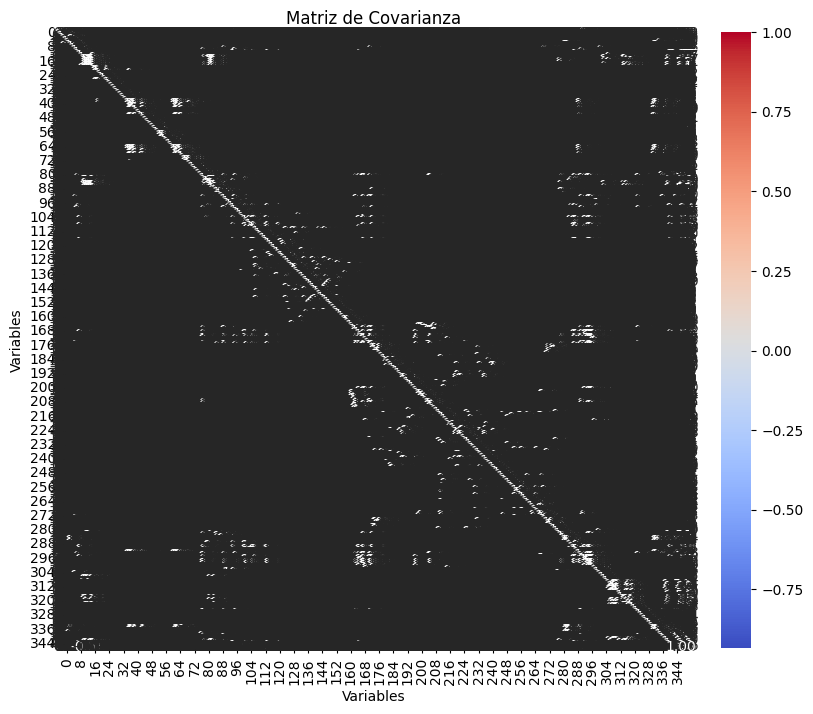

In [84]:
# Crea el gráfico de mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cov_azdias, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)

# Configura los títulos y etiquetas de los ejes
plt.title('Matriz de Covarianza')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Muestra el gráfico
plt.show()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Part 1 a) Appling sklearn PCA class

By using PCA (Principal Component Analysis PCA) analysis, we can reduce the residual data without losing the data. 

The PCA class will be used to apply the Analysis Manager to the data to find the vector with the highest variance in the data. First, at least half of the features will be set (so that there are enough features in the transition to see a general pattern). 

The ratio of variance explained by each factor relative to the variance explained can be analyzed graphically or meaningfully using matplotlib's plot() function. Based on the findings, the cost for the number of features replaced will be reserved for the common part of the project.



In [85]:
# Apply PCA to the data.
pca = PCA()

In [86]:
### Part 1 a.1) Appling sklearn PCA class Azdias Data

In [87]:
pca_azdias = pca.fit_transform(azdias_scaled)
var_exp = pca.explained_variance_ratio_

In [88]:
def show_plot(pca, name): 
    '''
    Creates a plot associated with the principal components 
    
    :pca -> the result of instantian of PCA 
    :name -> name of the Dataframe
    
    return -> graphic with the componenets
    
    '''
    plt.plot(np.cumsum(var_exp))
    plt.title('Graphic:  Principal Components -  {}'.format(name))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance')

plt.show()

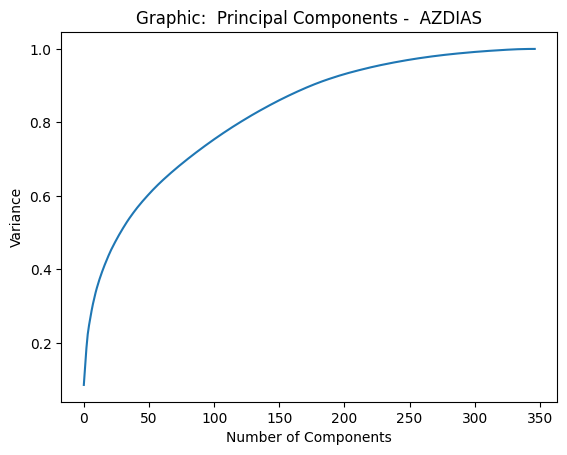

In [89]:
show_plot(pca_azdias,'AZDIAS')

In [90]:
#customers pca

In [91]:
print('Covariance matrix: \n%s' %np.cov(azdias_scaled.T))

Covariance matrix: 
[[ 1.00000133e+00  1.06916429e-03  5.99658763e-03 ... -1.10645861e-04
  -8.22287833e-02 -2.49285757e-02]
 [ 1.06916429e-03  1.00000133e+00  1.74551713e-02 ... -1.06616912e-01
   3.91889747e-02 -2.62868403e-02]
 [ 5.99658763e-03  1.74551713e-02  1.00000133e+00 ... -2.01445305e-01
   1.60646630e-01 -1.28507215e-01]
 ...
 [-1.10645861e-04 -1.06616912e-01 -2.01445305e-01 ...  1.00000133e+00
  -5.59666186e-02  1.04545375e-01]
 [-8.22287833e-02  3.91889747e-02  1.60646630e-01 ... -5.59666186e-02
   1.00000133e+00 -4.61152219e-01]
 [-2.49285757e-02 -2.62868403e-02 -1.28507215e-01 ...  1.04545375e-01
  -4.61152219e-01  1.00000133e+00]]


In [92]:
### Part 1 a.2) Appling sklearn PCA class Customers Data

In [93]:
pca_customers = pca.fit_transform(customers_scaled)

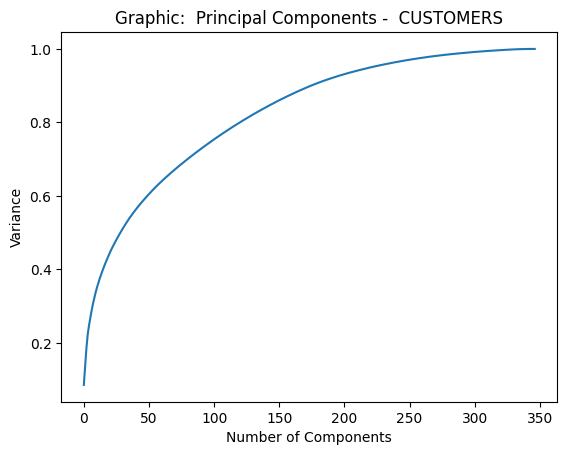

In [94]:
show_plot(pca_customers,'CUSTOMERS')

In [95]:
print('Covariance matrix: \n%s' %np.cov(customers_scaled.T))

Covariance matrix: 
[[ 1.00000718e+00  9.14123206e-04 -1.45363450e-03 ... -2.68608779e-03
   2.36829738e-03 -1.44187015e-03]
 [ 9.14123206e-04  1.00000718e+00  1.76434361e-02 ... -1.89987005e-01
   6.29269398e-02 -3.20122342e-02]
 [-1.45363450e-03  1.76434361e-02  1.00000718e+00 ... -8.64823219e-02
   8.76470177e-02 -3.46130810e-02]
 ...
 [-2.68608779e-03 -1.89987005e-01 -8.64823219e-02 ...  1.00000718e+00
  -1.49465274e-02  5.89165777e-02]
 [ 2.36829738e-03  6.29269398e-02  8.76470177e-02 ... -1.49465274e-02
   1.00000718e+00 -3.65673034e-01]
 [-1.44187015e-03 -3.20122342e-02 -3.46130810e-02 ...  5.89165777e-02
  -3.65673034e-01  1.00000718e+00]]


The last two plots  show cumulative explained data variance by components. Whatching the curve we can decide that with 150 features we have above more 80% data variance.



### Part 1 a.3) Reducing Dimensionality

In [96]:

def reduceDimensionality(df, components): 
    '''
    Reducing Dimensionality
    
    :df -> DataFrame to reduce Dimensionality
    :components -> number of features
    
    
    return -> returns df with reduced Dimensionality only with n components
    '''
    
    pca = PCA(components)
    
    df_reduced = pca.fit_transform(df)
    df_reduced = pd.DataFrame(df_reduced)
    
    print('Data variance by top {} components is equal to '. format(components) + str(pca.explained_variance_ratio_.sum())) 
         
    
    return  df_reduced

In [97]:
azdias_pca_reduced = reduceDimensionality(azdias_scaled,150)

Data variance by top 150 components is equal to 0.8558065385416812


In [98]:
azdias_pca_reduced.shape

(751217, 150)

In [99]:
customers_pca_reduced = reduceDimensionality(customers_scaled,150)

Data variance by top 150 components is equal to 0.8407432628096446


In [100]:
customers_pca_reduced.shape

(139286, 150)

### Part 1 b) Appling K-MEANS, an unsupervised machine learning algorithm

The algorithm aims to divide the data into k groups based on the similarity of the characteristics of the data. The method involves assigning points to groups so that points in the same group are more similar than points in other groups. 

In [101]:
def applyKmeans(data, n_clusters):
    '''
    Dividing data in k groups based on similarity of the features
    
    :data -> DataSet to be clustered
    :n_clusters -> Number of clusters to divided the info
    
    
    return -> returns the absolute value of the model's score applied to the data
    '''
    
    kmeans = KMeans(n_clusters)
    
    model = kmeans.fit(data)
    
    return abs(model.score(data))

In [102]:
cluster_distances =[]
for n_cluster in range(2, 21):
     cluster_distances.append(applyKmeans(azdias_pca_reduced.sample(20000), n_cluster))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

### Part 1 c) Elbow Graph

Elbow graph a tool used to determine the optimal number of clusters in a clustering algorithm, such as K-Means. 
The number of clusters corresponding to the elbow point in the graph is considered as the optimal number of clusters, as it balances the model's fitting ability with the simplicity and interpretability of the results.

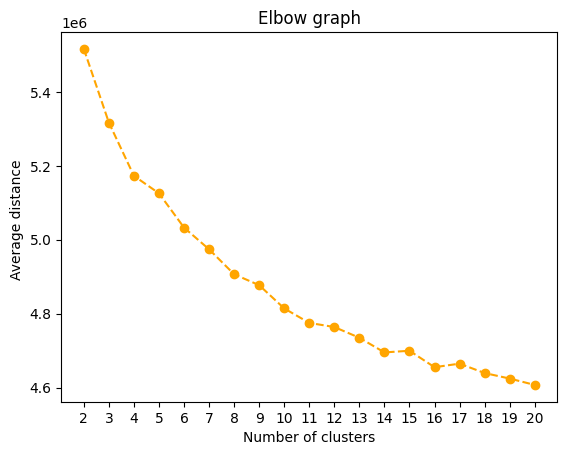

In [103]:
clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(clusters, cluster_distances, \
        linestyle= "--",marker = "o", color="orange")
plt.xticks(ticks=clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance ')
plt.title('Elbow graph')


plt.show()

We can observe that within-cluster distances decrease at a high rate until reaching 12.
We come to the conclusion that 12 is the optimal number of clusters for AZDIAS.

In [104]:
n_clusters = 12

kmeans = KMeans(n_clusters)

### Part 1 d) Fitting the model to the Data

In [105]:

azdias_clusters = kmeans.fit_predict(azdias_pca_reduced)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [106]:
azdias_clusters

array([ 2,  0, 10, ...,  0,  2,  4], dtype=int32)

In [107]:
customers_clusters = kmeans.fit_predict(customers_pca_reduced)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [108]:
customers_clusters

array([ 9,  0,  8, ..., 10,  0,  3], dtype=int32)

### Part 1 e) Comparing data: AZDIAS (general population) and CUSTOMERS  for each cluster.

Calculing  the count of data points assigned to each cluster in a column named "Population"  and in the column "Customer"

In [109]:
cluster_info = pd.DataFrame([])


cluster_info["Population"] = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_clusters).value_counts().sort_index()


cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)


In [110]:
cluster_info

,Cluster,Population,Customer
0,0,87784,13408
1,1,61659,9980
2,2,63922,4978
3,3,53189,13106
4,4,85015,17080
5,5,52409,9138
6,6,43030,7528
7,7,62343,9767
8,8,46674,17711
9,9,62586,18372



Calculing  the percentage of the general population that each cluster represents in a new column named "General population"


In [111]:

cluster_info['General population'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)


Calculing  the percentage of Customer that each cluster represents in a new column named "Customer Base"

In [112]:

cluster_info['Customer Base'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)

In [113]:
### Part 1 f) Comparing data: AZDIAS (general population) and CUSTOMERS   for each cluster.

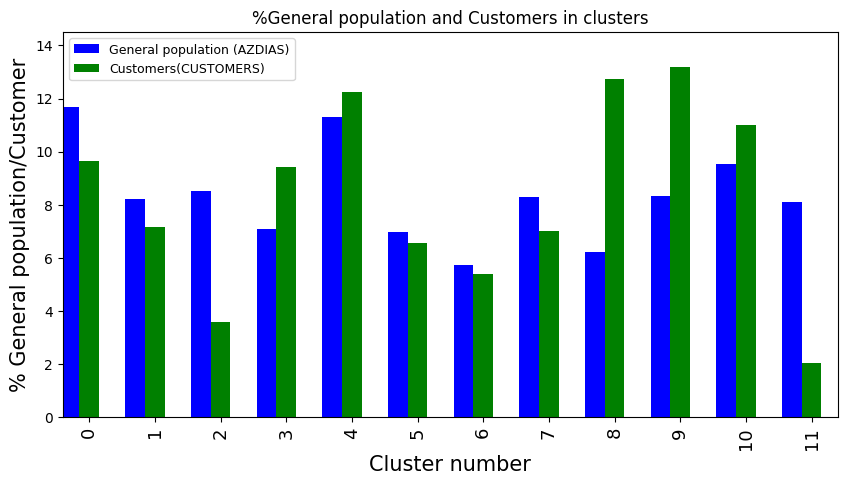

In [114]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)

ax = cluster_info['General population'].plot(x=cluster_info['Cluster'], \
                                                  width=-0.3, align='edge', \
                                                  color='blue', kind='bar', position=0)


ax = cluster_info['Customer Base'].plot(kind='bar', color='green', width = 0.3, align='edge', position=1)

ax.set_xlabel('Cluster number', fontsize=15) 
ax.set_ylabel('% General population/Customer', fontsize=15)

#ax.xaxis.set(ticklabels=range(21))

ax.xaxis.set(ticks=range(12), ticklabels=range(12))

ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General population (AZDIAS)', 'Customers(CUSTOMERS)'), fontsize=9)
plt.title(('%General population and Customers in clusters'))

plt.show()

The distribution of General Population is more uniform.
The Customers are mostly from clusters 3,4,8,9,10.

Some clusters are overrepresented by customers but in the other clusters don´t.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [115]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [116]:
mailout_train = pd.read_csv('mailout_train.csv', sep=';')
mailout_test = pd.read_csv('mailout_test.csv', sep=';')

/var/folders/d0/tf150l_x1c99_t8sk43b8s1m0000gn/T/ipykernel_92009/441051834.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('mailout_train.csv', sep=';')
/var/folders/d0/tf150l_x1c99_t8sk43b8s1m0000gn/T/ipykernel_92009/441051834.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('mailout_test.csv', sep=';')


In [117]:
## Part 2: a)Get to Know the Data

In [118]:
mailout_train.shape

(42962, 368)

In [119]:
# Checking

#how the data is balanced
(mailout_train.RESPONSE == 1).mean()

0.012383036171500396

In [120]:
print(mailout_train.RESPONSE.value_counts())


0    42430
1      532
Name: RESPONSE, dtype: int64


The responser only are th 1,24%. The colum Response is very unbalanced an accuracy evaluation just does not fit for this problem. 
To our case we are choosing ROC-AUC evaluation metric.



In [121]:
### output percentage of values that are missing by columns

missing_cols_mailout_train = mailout_train.isnull().mean(axis=1) * 100
missing_cols_mailout_train

0        1.358696
1        1.086957
2        2.173913
3        1.358696
4        1.358696
           ...   
42957    1.086957
42958    1.086957
42959    1.358696
42960    1.086957
42961    1.358696
Length: 42962, dtype: float64

Text(0.5, 1.0, 'Proportion of missing values in Mailout train features')

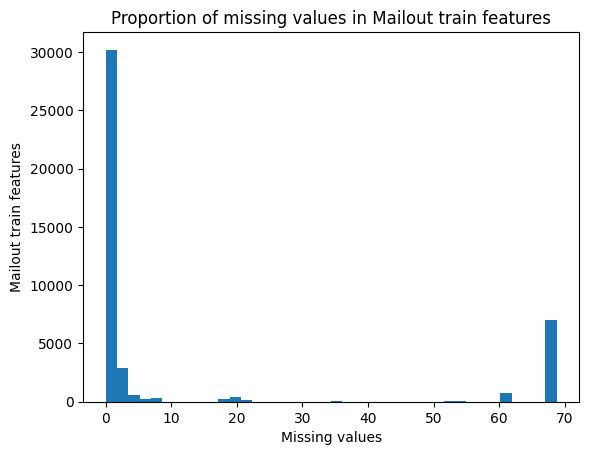

In [122]:
plt.hist(missing_cols_mailout_train, bins=40);

plt.xlabel('Missing values')
plt.ylabel('Mailout train features')
plt.title('Proportion of missing values in Mailout train features')

In [123]:
## Checking columns with nulls
list_mailout_train_nulls = find_columns_nulls(mailout_train,0.20)

print(list_mailout_train_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'HH_DELTA_FLAG', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_

In [124]:
list_mailout_test_nulls = find_columns_nulls(mailout_test,0.20)

print(list_mailout_test_nulls)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'HH_DELTA_FLAG', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH']


In [125]:
mailout_train.drop(list_mailout_train_nulls,axis=1,inplace=True)

In [126]:
#display_null_columns(mailout_train,'mailout_train',list_mailout_train_nulls,0.20)

In [127]:
mailout_train = replaceUnknowns(mailout_train, dias_attributes_val_unknowns)
mailout_train.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,1763.0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1.0,1771.0,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1.0,0.0,2.0,3.0
2,2.0,1776.0,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3.0,0.0,1.0,4.0
3,3.0,1460.0,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3.0,0.0,2.0,4.0
4,4.0,1783.0,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3.0,0.0,1.0,3.0
5,5.0,1789.0,3.0,1.0,12.0,12.0,17.0,0.0,0.0,1.0,...,4.0,2.0,1.0,1.0,9.0,2.0,3.0,0.0,2.0,3.0
6,6.0,1795.0,1.0,1.0,8.0,8.0,2.0,0.0,0.0,1.0,...,1.0,6.0,6.0,3.0,9.0,2.0,3.0,0.0,2.0,4.0
7,7.0,1493.0,2.0,1.0,13.0,13.0,1.0,0.0,0.0,2.0,...,0.0,1.0,1.0,1.0,9.0,7.0,3.0,0.0,2.0,4.0
8,8.0,1801.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,2.0,3.0
9,9.0,1834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,1.0,1.0


In [128]:
## Part 2: b)Cleanning data

In [129]:
# Cleaning data
mailout_train_processed = processData(mailout_train,dias_attributes_val_new,30,'mailout_train')


1. Replacing X, XX with NaN
2. Dropping rows with missing values higher than 30
3. Re-encoding EINGEFUEGT_AM
4. Processing CAMEO_DEUG_2015
5. ncoding binaries values
6. Dropping CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
7. Spliting CAMEO_INTL_2015 in Wealth_level and Status
8. Encoding cols starting LP* an cols PRAEGENDE_JUGENDJAHRE


In [130]:
# Missing values
mailout_train_processed.isnull().sum().sum()

0

In [131]:
mailout_train_processed.shape

(35000, 291)

In [132]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763.0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1771.0,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1.0,0.0,2.0,3.0
2,1776.0,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3.0,0.0,1.0,4.0
3,1460.0,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3.0,0.0,2.0,4.0
4,1783.0,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338.0,2.0,1.0,0.0,10.0,1.0,0.0,0.0,2.0,2.0,...,3.0,1.0,1.0,1.0,8.0,7.0,1.0,0.0,1.0,4.0
42958,67629.0,NaN,1.0,0.0,14.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,1.0,1.0,9.0,7.0,1.0,0.0,1.0,3.0
42959,68273.0,1.0,1.0,16.0,10.0,2.0,0.0,0.0,3.0,2.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1.0,0.0,1.0,4.0
42960,68581.0,2.0,1.0,18.0,13.0,3.0,0.0,0.0,3.0,2.0,...,3.0,2.0,3.0,4.0,9.0,2.0,3.0,0.0,2.0,4.0


In [133]:
mailout_train_processed.shape

(35000, 291)

In [134]:
mailout_train.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'RESPONSE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=295)

#### Part 2: c) Metrics

How we explained early using ROC AUC (Receiver Operating Characteristic Area Under the Curve) metric we can  to evaluate the quality and performance of a binary classification model.

In a binary classification problem, where the goal is to predict between two classes (e.g., "positive" and "negative" just like our case), the model assigns a score or probability to each example indicating the confidence in the classification. The ROC curve is constructed by plotting the true positive rate (sensitivity) against the false positive rate (1-specificity) at different classification thresholds.



The cross validation strategy: we will use Stratified KFold, a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [135]:

mailout_train_Y = pd.DataFrame(mailout_train_processed['RESPONSE'].values,columns=['RESPONSE'])#labels
mailout_train_X = mailout_train_processed.drop(['RESPONSE', 'LNR'],axis=1)


In [136]:
#esto es para escalar
#scaler = StandardScaler()

#mailout_train_X = pd.DataFrame(scaler.fit_transform(mailout_train_processed), columns = mailout_train_processed.columns)

In [137]:

X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, mailout_train_Y, test_size=0.2)

In [138]:

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 5583 to 14369
Columns: 289 entries, AGER_TYP to CAMEO_INTL_2015_STATUS
dtypes: float64(289)
memory usage: 62.0 MB


#### Part 2: d.1) Implementation Model. Reference point before scaling data.

We are going to mark the point of reference before scaling data. We are to train differents model on unscaled data.


In [139]:
def modelTraining(classifier, X_train, y_train, X_val, y_val):
    '''
    This function  trains a specified classifier model using 
    the provided training data and labels, 
    evaluates its performance on the validation data, 
    and returns the ROC-AUC score and training time.
    
    :classifier-> model to use
    :X_train-> training data
    :y_train-> training labels
    :X_val-> validation data
    :y_val-> validation labels
    
    return: ROC-AUC score, training time
    '''
    
    t = time.time()
    classifier = classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict_proba(X_val)[:,1]
    
    roc_score = roc_auc_score(y_val, y_pred)
    train_time = time.time() - t
    
    
    return roc_score, train_time

These are the classifier model we are going to try:


AdaBoost (AdaBoostClassifier):Its goal is  to improve classification accuracy by assigning weights to training examples and restoring poor classification to focus on events that have been misclassified in the past. 

Gradient Boosting (GradientBoostingClassifier): Combines weak classifiers into strong classifiers. Unlike AdaBoost, this one  uses the gradient optimization method to reduce the loss function and gradually improve the performance of the model. 

Random Forest (RandomForestClassifier): This one combines multiple decision trees for classification. Each tree is trained on a sample of the training data and makes predictions. 
The final estimate is determined by a tree's majority vote, this caracteristic  making it a powerful classifier that is resistant to overfitting. 

XGBoost (XGBClassifier): This classifier  leverages  techniques such as regularization and tree pruning to improve performance and control overhead.
It is known for its performance and accuracy in many machine learning challenges. 

K Nearest Neighbors (KNeighborsClassifier): It is an instance-based classification algorithm that assigns a new sample to the class of K neighbors according to the distance measure. It's simple method, but  work well for small data or where the idea of community is important to the problem.


Decision Tree (DecisionTreeClassifier): It is a supervised learning algorithm that creates a decision tree from the given data. Each root of the tree represents a feature, each branch a decision rule, and each leaf a list.
Decision trees are easy to define and can have numerical and categorical variables.

In [140]:
classifiers = [
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
    ("LogisticRegression",LogisticRegression(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("XGBClassifier",xgb.XGBClassifier(random_state=42)),
    ("Nearest Neighbors", KNeighborsClassifier(3)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42))
        
]

In [141]:
def executeClassifiers(classifiers, X_train, y_train, X_val, y_val, type_scaled):
    
    '''
    Choose every classifier from a list of classifier and train the data with model choosen
   

    :classifiers-> the list of the classifiers
    :X_train-> training data
    :y_train-> training labels
    :X_val-> validation data
    :y_val-> validation labels
    :type_scaled-> what kind of scaled we used
    
    :returns-> dataframe of results for comparison
    '''
    
    result={
    'classifier':[],
    'roc_score':[],
    'train_time':[],
    'type_scaled':[]
    }
    
    
    for name, classifier in classifiers:
        
        roc_score, t = modelTraining(classifier, X_train, y_train, X_val, y_val)
        result['classifier'].append(name)
        result['roc_score'].append(roc_score)
        result['train_time'].append(t)
        result['type_scaled'].append(type_scaled)
        
        
    results_df = pd.DataFrame.from_dict(result, orient='index').transpose()
    results_df.sort_values(by=['roc_score','train_time'],ascending=False,inplace=True)   
    
    return results_df

In [142]:

df_no_scaled = executeClassifiers(classifiers, X_train, y_train, X_val, y_val,'no scaled')
df_no_scaled

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,classifier,roc_score,train_time,type_scaled
1,GradientBoostingClassifier,0.77717,26.988718,no scaled
0,AdaBoost,0.760781,5.244433,no scaled
4,XGBClassifier,0.732003,5.084786,no scaled
2,LogisticRegression,0.686096,1.308795,no scaled
3,Random Forest,0.660964,4.379401,no scaled
5,Nearest Neighbors,0.500497,0.68893,no scaled
6,Decision Tree,0.49634,1.18417,no scaled


From the table above we can conclude that the betters scores are given by  XGBoost, AdaBoost and Gradient Boosting classifiers. Adaboost and Gradient are close by Ada is so fast than the Gradient.

In [143]:
#### Part 2: d.2) Implementation Model with scaled data using StandardScaler

Benchmark performance that we aim to improve upon.

In [144]:
mailout_train_X_scaled = pd.DataFrame(scaler.fit_transform(mailout_train_processed), columns = mailout_train_processed.columns)

In [145]:

X_train, X_val, y_train, y_val = train_test_split(mailout_train_X_scaled, mailout_train_Y, test_size=0.2)

In [146]:
df_standardscaler =executeClassifiers(classifiers, X_train, y_train, X_val, y_val,'StandardScaler')
df_standardscaler

,classifier,roc_score,train_time,type_scaled
1,GradientBoostingClassifier,1.0,8.971329,StandardScaler
3,Random Forest,1.0,3.269083,StandardScaler
4,XGBClassifier,1.0,1.421847,StandardScaler
2,LogisticRegression,1.0,0.294778,StandardScaler
0,AdaBoost,1.0,0.1189,StandardScaler
6,Decision Tree,1.0,0.105232,StandardScaler
5,Nearest Neighbors,0.977223,0.680411,StandardScaler


In [147]:
#### Part 2: d.3) Implementation Model with scaled data using MinMaxScaler

In [148]:
min_max_scaler = MinMaxScaler()

In [149]:
mailout_train_X_scaled_min_max = pd.DataFrame(min_max_scaler.fit_transform(mailout_train_processed), columns = mailout_train_processed.columns)

In [150]:

X_train, X_val, y_train, y_val = train_test_split(mailout_train_X_scaled_min_max, mailout_train_Y, test_size=0.2)

In [151]:
df_minmaxscaler = executeClassifiers(classifiers, X_train, y_train, X_val, y_val,'MinMaxScaler')
df_minmaxscaler

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,classifier,roc_score,train_time,type_scaled
1,GradientBoostingClassifier,1.0,9.157668,MinMaxScaler
3,Random Forest,1.0,3.374098,MinMaxScaler
4,XGBClassifier,1.0,3.123601,MinMaxScaler
2,LogisticRegression,1.0,1.760864,MinMaxScaler
0,AdaBoost,1.0,0.12194,MinMaxScaler
6,Decision Tree,1.0,0.110537,MinMaxScaler
5,Nearest Neighbors,0.583608,0.91724,MinMaxScaler


In [152]:
results_concatenaded = df_no_scaled.merge(df_standardscaler,on='classifier').merge(df_minmaxscaler,on='classifier')

In [153]:
results_concatenaded

,classifier,roc_score_x,train_time_x,type_scaled_x,roc_score_y,train_time_y,type_scaled_y,roc_score,train_time,type_scaled
0,GradientBoostingClassifier,0.77717,26.988718,no scaled,1.0,8.971329,StandardScaler,1.0,9.157668,MinMaxScaler
1,AdaBoost,0.760781,5.244433,no scaled,1.0,0.1189,StandardScaler,1.0,0.12194,MinMaxScaler
2,XGBClassifier,0.732003,5.084786,no scaled,1.0,1.421847,StandardScaler,1.0,3.123601,MinMaxScaler
3,LogisticRegression,0.686096,1.308795,no scaled,1.0,0.294778,StandardScaler,1.0,1.760864,MinMaxScaler
4,Random Forest,0.660964,4.379401,no scaled,1.0,3.269083,StandardScaler,1.0,3.374098,MinMaxScaler
5,Nearest Neighbors,0.500497,0.68893,no scaled,0.977223,0.680411,StandardScaler,0.583608,0.91724,MinMaxScaler
6,Decision Tree,0.49634,1.18417,no scaled,1.0,0.105232,StandardScaler,1.0,0.110537,MinMaxScaler


We can see that without scaling data AdaBoost and GradienBoost have the best roc score, but is much faster AdaBoost. Using scaling data (StandardScaler and MinMaxScaler) the roc score  is 1 using StandardScaler and MinMaxScaler. AdaBoost is faster using StandardScaler.


In [154]:
%%time

AdaBoost_param_dict = {
 'n_estimators': [25, 50, 100, 150, 200],
 'learning_rate' : [0.01,0.05,0.1,0.3,0.5,1] }

agrid = GridSearchCV(estimator = AdaBoostClassifier(random_state=42),
                     param_grid = AdaBoost_param_dict,
                     scoring = "roc_auc",
                     cv = 5,
                     n_jobs=-1, 
                     verbose=2)

CPU times: user 760 µs, sys: 917 µs, total: 1.68 ms
Wall time: 287 µs


We can conclude that what are best parameters for the AdaBoost Classifier. From now one we can fit with agrid.best_estimator_

Next we should find best parameters for the XGBoost Classifier